<a href="https://colab.research.google.com/github/bratzaharia/wine-quality-scoring/blob/main/Project2_Wine_Quality_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scenariu: Crama Vinuri Selecte ți-a furnizat un fișier CSV cu analize chimice ale vinurilor și scorul de calitate dat de un panel de experți (de la 0 la 10). Fiecare rând din fișier reprezintă un lot de vin, iar coloanele conțin informații precum aciditate, pH, conținut de alcool, zahăr rezidual și alți indicatori tehnici măsurați în laborator. Ținta este să construiești un program care să prezică calitatea vinului și să îl prezinți cramei.

Ce trebuie să livrezi în acest notebook:

Încărcarea datelor.
Construirea unui model de ML (alegerea îți aparține)
Explicații business-oriented:
Cum arată dataset-ul (variabile, tipuri, observații relevante).
Limitări ale dataset-ului (lipsa informațiilor despre soi, brand, preț; clase neechilibrate).
De ce ai ales modelul X și cum îl interpretezi.
Rezultate (exemplu: accuracy, matrice de confuzie) și ce înseamnă pentru cramă.
Ce ai face pentru a îmbunătăți performanța (tuning, transformări, date suplimentare).

In [7]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import copy


pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

path = f"https://raw.githubusercontent.com/shrikant-temburwar/Wine-Quality-Dataset/master/winequality-red.csv"

# df_raw = pd.read_csv(path)
# print(df_raw.head())
df_raw = pd.read_csv(path, sep=";")
df_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
print("(linii, coloane):", df_raw.shape)
df_raw.info()

(linii, coloane): (1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
df_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [13]:
# Verificat valori null
# df_raw.isnull().sum().value_counts(dropna=False).head(20)

# Verificare valori duplicate:
df_raw.duplicated().sum()
df_raw[df_raw.duplicated()].head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.9966,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.9978,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.9962,3.41,0.39,10.9,5
76,8.8,0.410,0.64,2.20,0.093,9.0,42.0,0.9986,3.54,0.66,10.5,5
91,8.6,0.490,0.28,1.90,0.110,20.0,136.0,0.9972,2.93,1.95,9.9,6
93,7.7,0.490,0.26,1.90,0.062,9.0,31.0,0.9966,3.39,0.64,9.6,5
102,8.1,0.545,0.18,1.90,0.080,13.0,35.0,0.9972,3.30,0.59,9.0,6
105,8.1,0.575,0.22,2.10,0.077,12.0,65.0,0.9967,3.29,0.51,9.2,5


In [18]:
# delete duplicates
df = df_raw.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

np.int64(0)

In [19]:
# verifi daca in col numerice exista nr negative
num_cols = df_raw.select_dtypes(include='number').columns
(df_raw[num_cols] < 0).sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [22]:
# procent de lipsuri
missing_percent = df_raw.isnull().mean() * 100

print("\nProcent valori lipsă (%):")
print(missing_percent.sort_values(ascending=False))


Procent valori lipsă (%):
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64


In [23]:
df_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Valorile explicate!

1. fixed acidity - Acizi care nu se evaporă (tartric, malic). Dau structură vinului. Interval tipic: ~4 - 16; impact: prea mic → vin fad; prea mare → vin prea aspru. (nu e liniar!)
2. volatile acidity - Acizi volatili (mai ales acid acetic → gust de oțet). Interval: ~0.1 – 1.6. Foarte negativă ➡ valori mari = defect de vinificație
Calitate ridicată: cât mai mică - o valoare importanta!
3. citric acid: Dă prospețime și stabilitate. Interval: ~0 - 1. Calitate ridicată: moderată; 0 → vin plat, prea mare → gust artificial. De obicei pozitiv ușor.
4. residual sugar: Zahăr rămas după fermentare.Interval: vin sec: < 4, vin dulce: mult mai mare. Depinde de tipul vinului! În dataset: mai mic e mai bine (majoritatea sunt seci). Valori mari apar des la vinuri de calitate slabă.
5. chlorides (sare): Conținut de sare (sodiu). Interval: ~0.01-0.6. Negativ -
prea mult → gust sărat, defect. Calitate ridicată: cât mai mic.
6. free sulfur dioxide: SO₂ liber- protejează vinul de bacterii. Interval: ~1- 70. E bun până la un punct. Calitate ridicată: mediu, nu extrem, prea mic → instabil, prea mare → miros neplăcut, ușor pozitiv, dar cu limită.
7. total sulfur dioxide: SO₂ total (liber + legat). Interval: ~6-300; Negativ când e mare, calitate ridicată: mai mic.
8. density: densitatea vinului (legată de alcool + zahăr). Interval: ~0.990-1.005. Valori mari = mult zahăr / alcool mic. Calitate ridicată: mai mică.
9. pH: măsoară aciditatea percepută. Interval: aprox 2.7-4.0. !Extrem de important echilibrul. Calitate ridicată: mediu (~3.2-3.4). Prea mic → prea acid, prea mare → fad. Relație NON-liniară.
10. sulphates: contribuie la stabilitate și aromă. Interval: ~0.3-2. Pozitiv (până la limită). Valori mai mari → vin mai „puternic”, mai structurat prea mare → gust amar.
11. alcohol: conținutul de alcool (% vol). Interval: ~8-14.5. CEL MAI PUTERNIC FACTOR POZITIV => alcool mai mare = vin mai complex, aromat
12. quality (TARGET) = scor dat de experți (0-10).


Din descrierea profesionistilor rezulta ca un vin bun este influentat de valori mici pentru unele features/proprietati, cum ar fi aciditatea volatila, zaharul rezidual sau densitate, valori medii pentru aciditatea fixa, SO2 liber sau valori moderate pt sulfiti su acid citric. Unele valori mari ca alcolul influenteaza direct calitatea vinului pozitiv.








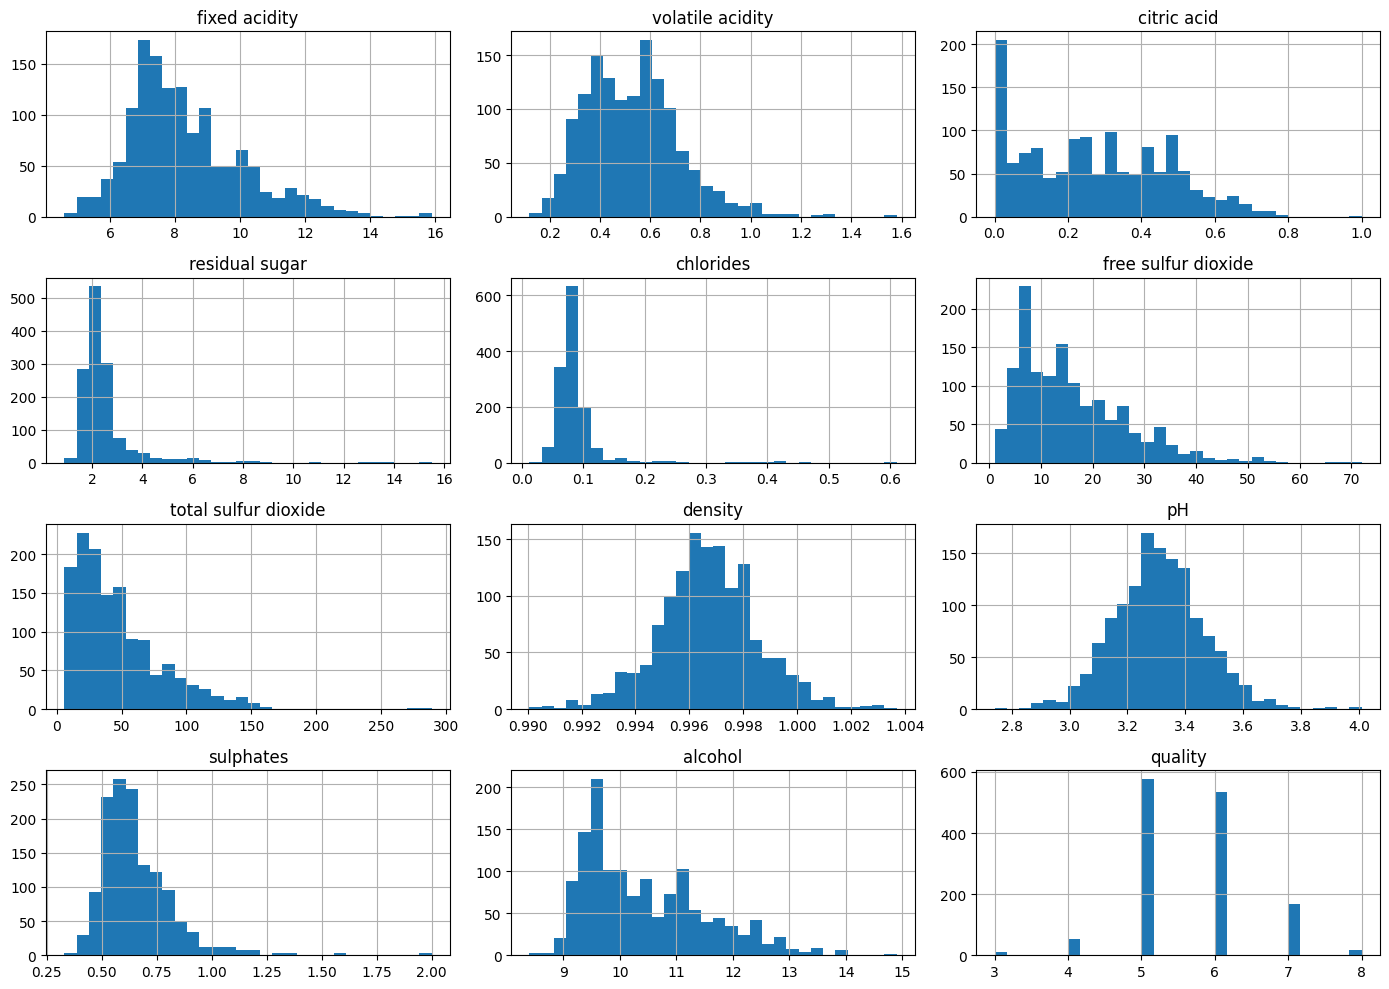

In [24]:
# EDA
df.hist(figsize=(14,10), bins=30)
plt.tight_layout()
plt.show()